In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

In [4]:
import tensorflow as tf
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl

In [13]:
from trading_model import MarketEnvironment, Observation
from investor_model_cnn import new_actor, new_critic
from project_utils import plot_behaviour, validate, validate_samples, qfun_from_rewards, trading_trajectory
from trading_sine_waves import SINX_COSX

---
# Trading Sine Waves

### Putting the Training Setup to a Test 
Before we engage in a full-blown noisy market model with our setup, we'd better try it at a super-trivial - yet similar - problem. It should be able to solve this. Only after we succeed here it makes sense to conquer the rest of the world. Here's where we can still tell whether it's a bug or just an inappropriate architecture choice, if it doesn't work.

### Sine-like waves are simple and easy to exploit
The goal of this exercise is to provide a super-simple trading problem that any chartist would outperform the market with. A synthetic equity called 'SINX' exhibits a wave-like structure. The clue is that the local extrema of the resulting chart are easily exploitable: If it looks like a *turnaround signal*, it is a turnaround signal! So a chartist would simply have to observe the last 2 prices at any point in time. If the trend turns, it'll stay in the new direction for long enough to profit from it. To make it slightly less easy we introduce a second equity called 'COSX'. Now the claim is: Every trading algorithm that is supposed to learn patterns MUST be able to exploit this trivial market. Note that we can claim so exactly because this market exhibits *inertia* - i.e. continuity in movement.

In [14]:
## the market
market = SINX_COSX(fee=1e-2)

#### Heuristic exploitation
By simply tracking the change of sign of the first derivative we can identify the ideal transaction times. Yes, for the heuristics we ignore the possible influence of transaction costs.

In [15]:
duration=400
df = pd.DataFrame([market.prices(t) for t in range(duration)], columns=['SINX', 'COSX'])

In [16]:
df['DELTA_SINX'] = df['SINX'] - df['SINX'].shift()
df['DELTA_COSX'] = df['COSX'] - df['COSX'].shift()
df = df.dropna()

In [17]:
df['SIGN_DELTA_SINX'] = .5 * (np.sign(df['DELTA_SINX']) - np.sign(df['DELTA_SINX']).shift())
df['SIGN_DELTA_COSX'] = .5 * (np.sign(df['DELTA_COSX']) - np.sign(df['DELTA_COSX']).shift())

In [18]:
df['BUY COSX'] = df[['COSX']].where(df['SIGN_DELTA_COSX']>0)
df['SELL COSX'] = df[['COSX']].where(df['SIGN_DELTA_COSX']<0)
df['BUY SINX'] = df[['SINX']].where(df['SIGN_DELTA_SINX']>0)
df['SELL SINX'] = df[['SINX']].where(df['SIGN_DELTA_SINX']<0)

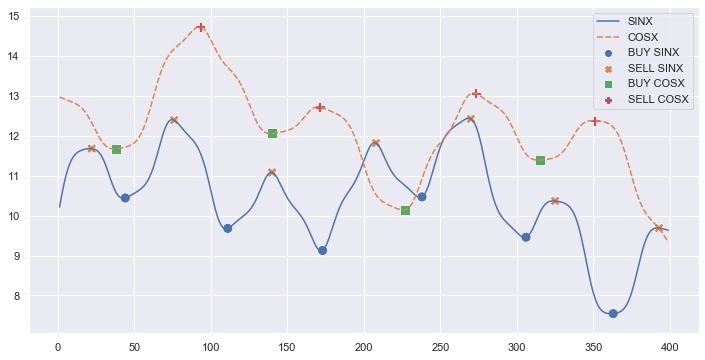

In [19]:
sns.lineplot(data=df[['SINX', 'COSX']]);
sns.scatterplot(data=df[['BUY SINX', 'SELL SINX', 'BUY COSX', 'SELL COSX']], s=100);

Will the deep reinforcement learning algorithm be able to understand those signals from trial and error? And what role to transaction costs play then?

---
## Convenient Helpers

#### Plot an Actor's Behaviour
```plot_behaviour``` plots the log returns of the indicated positions against the portfolio holdings of that agent. It also shows the total wealth as it develops over the duration of the episode.

In [20]:
market = SINX_COSX(fee=1e-2)

In [21]:
default_env = MarketEnvironment(
    market = market, 
    return_scale = 100,
    weight_scale = .1,
    n_hist = 7, 
    portfolio = [4e5, 3e5, 3e5],
    t_init = 7)
some_actor = new_actor(n_market=2, n_history=7, n_filters=4, n_portfolio=3, layers=[32,32])

wealth: 979166.9, portfolio: [342480.38 324082.56 312603.97]

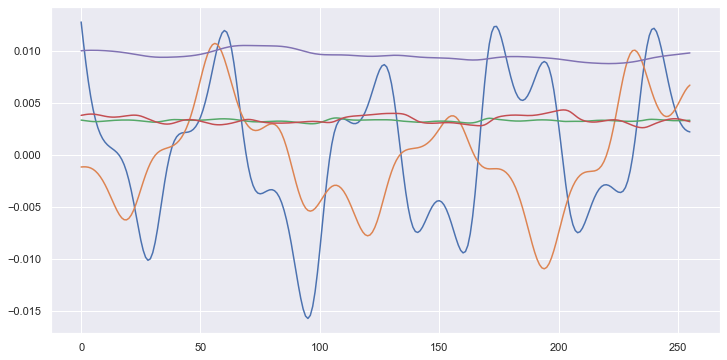

In [22]:
plot_behaviour(some_actor, default_env, duration=256, positions=[1,2])

#### Validate an Actor
Compute the actor's success in the market. The ```validate``` function returns the ratio between the total wealth at the end of the trading period and the initial wealth. A value larger than one would indicate some success, if the risk-free rate is zero. The second return value is the total of transaction fees.

In [23]:
validate(some_actor, default_env, duration=256, start_at=0)

(0.99573625, 29656.72)

#### Q-Function from the rewards
This function constructs the *true* Value function from the rewards collected on a given trajectory.

In [24]:
qfun_from_rewards([1, 2, 3, 4, 5], gamma=.99)

array([14.60447605, 13.741895  , 11.8605    ,  8.95      ,  5.        ])

#### Some exploration noise 

In [25]:
def uniform_noise(actions, kappa):
    """
    randomize the given actions
    params
    """
    assert(kappa >= 0)
    a1 = (1+kappa)**((np.random.random(actions.shape)-.5)) * actions
    return (a1.T/np.sum(a1, axis=-1)).T

Since the actions are contrained within the range $[0, 1]$, we won't expect a Gaussian distribution here. Adding initially uniform noise and then rescaling the sum of all actions leads to the following distributions with increasing kurtosis and a shift of the mean. We'll see that this kind of noise does a pretty good job in enforcing epxloration.

In [26]:
df = pd.DataFrame([
    [uniform_noise(np.array([.4,.1,.5]), noise)[0] for noise in [0.1, 2, 5, 10]]
    for i in range(10000)], columns=['0.1', '2', '5', '10'])

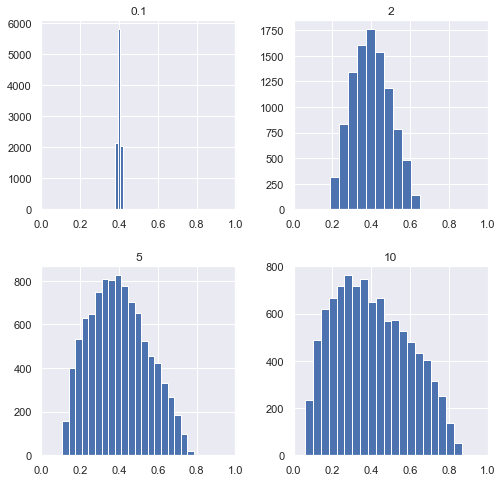

In [27]:
fig = plt.figure(figsize=(8,8))
ul = fig.add_subplot(2, 2, 1)
ur = fig.add_subplot(2, 2, 2)
ll = fig.add_subplot(2, 2, 3)
lr = fig.add_subplot(2, 2, 4)
ul.set_xlim([0, 1])
ur.set_xlim([0, 1])
ll.set_xlim([0, 1])
lr.set_xlim([0, 1])
df.hist(['0.1'], ax=ul, bins=3);
df.hist(['2'], ax=ur, bins=10);
df.hist(['5'], ax=ll, bins=20);
df.hist(['10'], ax=lr, bins=20);

#### An actor's SARS trajectory
Here you see the trajectory:
$$
\tau_i = (mh_i, pw_i, a_i, r_i, mh_{i+1}, pw_{i+1})
$$

With $mh$ being the observed market history up to the current time, $pw$ being the current portfolio weights, $a$ being the actions taken from there, and finally $r$ being the returns collected on during the episode. Note, that the state of the environment at time $t$ is given by the pair $(mh_t, pw_t)$.
```trading_trajectory``` shapes the market history so that it can be readily fed into a CNN.

In [28]:
traj = trading_trajectory(some_actor, default_env, 
                          lambda a, params: uniform_noise(a, params['step']/10), 
                          duration = 256, hold = 1)
[c.shape for c in traj]

[(256, 7, 2, 1), (256, 3), (256, 3), (256, 1), (256, 7, 2, 1), (256, 3)]

---
### Training the actor with heuristics

#### The *expert* - a simple heuristic
The SINX market has long, smooth periods of ups and downs. Once it turned upwards it'll continue for an exploitable period of time. The ```heuristic_hold``` helper here chooses the most recently best performing asset in an all-in fashion. Using supervised learning helps us verifying that our chosen neural network architecture is able to fit a successful model.

In [29]:
def heuristic_hold(x):
    """
    hold the asset with the highest total return during the most recent history period
    """
    batch_size = len(x)
    x1 = np.squeeze(x)
    sums = np.sum(x1, axis=1)
    sums_and_cash = np.hstack([np.zeros([batch_size, 1], dtype=np.float32), sums])
    max_sums = np.max(sums_and_cash, axis=-1)
    labels = ((sums_and_cash - max_sums.reshape([batch_size, 1])) == 0).astype(np.float32)
    return labels

In [30]:
n_batch = 256
n_history = 7
n_market = 2
n_portfolio = 3
n_filters = 8
actor_layers = [32, 32, 32, 32]
critic_layers = [32, 32, 32, 32]

In [31]:
eval_mh = 100*(np.random.random([100, n_history, n_market, 1]).astype(np.float32)-.5)
eval_pw = .1*np.random.random([100, n_portfolio]).astype(np.float32)

In [32]:
def generator():
    while(True):
        train_mh = 100 * (np.random.random([n_batch, n_history, n_market, 1]).astype(np.float32)-.5)
        train_pw = .1 * np.random.random([n_batch, n_portfolio]).astype(np.float32)
        x=[train_mh, train_pw]
        y=heuristic_hold(train_mh)
        yield((x,y))

In [33]:
some_actor = new_actor(n_market, n_history, n_filters, n_portfolio, actor_layers)
adam = tf.optimizers.Adam(learning_rate=1e-3)
some_actor.compile(adam, 'mse')

In [34]:
validation_data=([eval_mh, eval_pw], heuristic_hold(eval_mh))
history = some_actor.fit_generator(epochs = 100, generator=generator(),
                                   steps_per_epoch=10,
                                    verbose=0, 
                                   validation_data=validation_data)

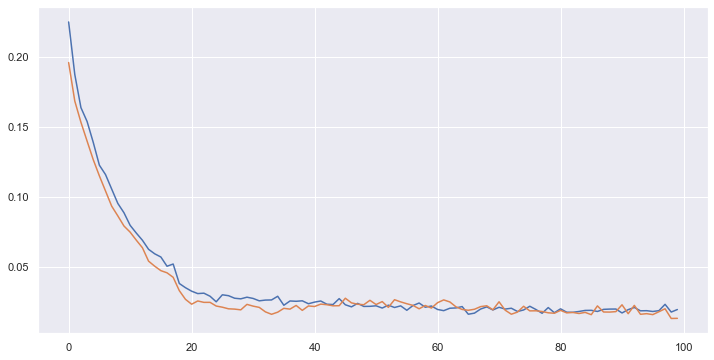

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

We can see that the heuristic tought our network to hold on to the best-performing stock at any point in time unless all stocks are going down in which case our agent piles up cash.

wealth: 1646126.2, portfolio: [  14041.05   21766.16 1610319.  ]

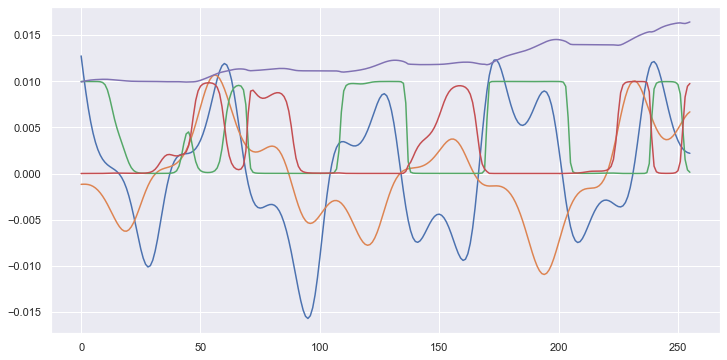

In [36]:
plot_behaviour(some_actor, default_env, positions=[1,2], duration=256)

# DDPG

## A variant of DDPG

The original Deep Deterministic Policy Gradient algorithm was defined like below

---

Using the discount factor $\gamma$ and the target learning rate $\tau$<br/>
Randomly initialize the primary networks</br>
Initialize the target networks $\mu^\prime$ and $Q^\prime$ with the weights of the primary network $\theta^\prime \leftarrow \theta$, $\phi^\prime \leftarrow \phi$</br>
Initialize replay buffer $R$</br>
**for** episode = 1, $N_E$ **do**</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Initialize random process $\mathcal N$ for action exploration</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Receive initial observation state $s_1$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**for** t=1, L (length of each episode), **do**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Select action $a_t = \mu(s_t|\theta) + \mathcal{N}_t$ according to the current policy and exploration noise<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Execute action $a_t$ and observe reward $r_t$ and new state $s_{t+1}$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Store transition $(s_t, a_t, r_t, s_{t+1})$ in $R$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Sample a random minibatch of $N_B$ transitions $(s_i, a_i, r_i, s_{i+1})$ from $R$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Calculate the $Q$-targets: $y_i = r_i + \gamma Q^\prime(s_{i+1}, \mu^\prime(s_{i+1}|\theta^\prime)|\phi^\prime)$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the primary critic by minimizing the loss: $L = \frac{1}{N_B}\sum_i(y_i-Q(s_i, a_i|\phi))^2$<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the actor policy using the sampled policy gradient:
$$
\nabla_\theta J \approx \frac{1}{N_B}\sum_{i=1}^{N_B}\nabla_a Q(s, a|\phi)|_{s=s_i, a=\mu(s_i)}
\nabla_\theta \mu(s|\theta)|_{s_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Update the target networks: 
$$
\theta^\prime \leftarrow \tau \theta + (1-\tau) \theta^\prime
$$

$$
\phi^\prime \leftarrow \tau \phi + (1-\tau) \phi^\prime
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**end for**<br/>
**end for**<br/>

---

The authors took a single sample in each iteration utilizing a replay buffer for efficiency. That's all good and important for continuous control use cases for which the algorithm has been developed. The portfolio problem is much less sensitive to straying from the perfect trajectory because even with a bad history of investments one can still learn well from new experience. That's completely different from robotics. When these guys are down on their backs they'll have to spend significant effort before they can continue learning to walk.

We'll sample a complete trading episode of some hundreds of rebalancing actions and continue our learning process from there without a replay buffer. We also initialize the environment stochastically to reduce self-induced bias. 

# DDPG - the Training

In [37]:
A_LAYERS = [64, 64, 64, 64]
C_LAYERS = [64, 64, 64, 64]
N_FILTERS = 8

N_M = 2
N_P = 3
N_H = 7
FEE = 2.5e-3

N_E = 50 # number of episodes for training
NOISE_LEVEL = 2.0
INITIAL_PORTFOLIO = [4e5, 3e5, 3e5]
N_STEPS = 256 # number of steps for each episode
N_HOLD = 1
N_UPDATE_CRITIC = 16
N_UPDATE_ACTOR = 1

RETURN_SCALE=100
WEIGHT_SCALE=.1
TARGET_SCALE=10

GAMMA = 0.999

TAU = 0.1

#### DDPG uses two actor-critic pairs

In [38]:
primary_critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P, layers=C_LAYERS)
pc_loss = tf.keras.losses.mean_squared_error
pc_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
primary_critic.compile(loss = pc_loss, optimizer=pc_optimizer)

primary_actor = new_actor(N_M, N_H, N_FILTERS, N_P, A_LAYERS)
pa_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

target_critic = new_critic(N_M, N_H, N_FILTERS, N_P, C_LAYERS)
target_critic.set_weights(primary_critic.get_weights())

target_actor = new_actor(N_M, N_H, N_FILTERS, N_P, A_LAYERS)
target_actor.set_weights(primary_actor.get_weights())

#### The initial behaviour - not so good

wealth: 967467.06, portfolio: [307865.28 296897.53 362704.25]

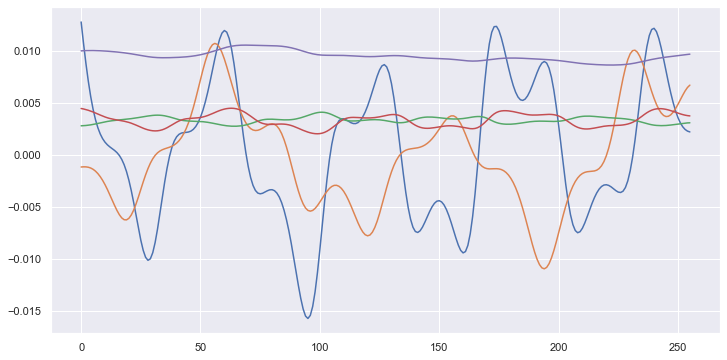

In [39]:
plot_behaviour(primary_actor, default_env, positions=[1,2], duration=256)

In [40]:
def new_environment(t=None):
    if t is None:
        t = np.floor(2000 * np.random.random()).astype(int)
    return MarketEnvironment(
        market = SINX_COSX(fee=FEE), 
        return_scale = RETURN_SCALE,
        weight_scale = WEIGHT_SCALE,
        n_hist = N_H, 
        portfolio = INITIAL_PORTFOLIO,
        t_init = t)

### Train!

(0.987121375, 13142.53)
(1.073614375, 14176.72)
(1.20966225, 17842.87)
(1.35890225, 23966.38)
(1.535154, 35724.45)
(1.69648875, 46113.19)
(1.821870375, 54119.99)
(1.90135575, 60499.26)
(1.966467125, 66057.78)
(2.007763125, 70362.29)
(2.044009125, 74114.44)
(2.10332325, 78737.31)
(2.14650775, 81540.42)
(2.19203075, 85101.87)
(2.23005525, 87116.05)
(2.256451, 89665.11)
(2.27207, 91811.68)
(2.285641, 94305.91)
(2.31223675, 95771.79)
(2.33757475, 97413.26)
(2.3512425, 98737.88)
(2.3671905, 99643.94)
(2.3763475, 100811.44)
(2.39357, 101193.06)
(2.41447225, 102346.38)
(2.4192025, 102982.49)
(2.42848575, 104834.8)
(2.43271525, 107712.07)
(2.44981475, 106859.06)
(2.469829, 104531.6)
(2.49798175, 106725.64)
(2.49846325, 107089.69)
(2.5108755, 107336.84)
(2.531111, 108416.46)
(2.5561385, 108900.41)
(2.5697575, 109123.21)
(2.56141025, 108785.56)
(2.579664, 108990.34)
(2.59308525, 109329.44)
(2.590506, 111930.89)
(2.57387625, 109659.64)
(2.593066, 111427.86)
(2.6099215, 113005.91)
(2.6270595, 1104

wealth: 2617077.0, portfolio: [7.0360999e+02 2.2075775e+06 4.0879609e+05]

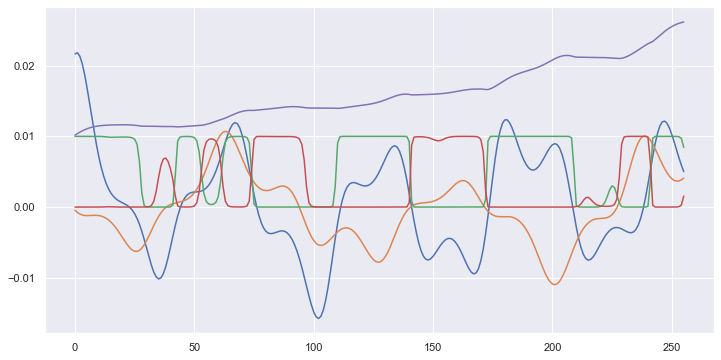

In [41]:
for i in range(N_E):

    env = new_environment()
    
    #
    #  Sample an entire episode
    #  Use a noise level that decreases over time
    #
    mh, pw, actions, returns, mh1, pw1 = trading_trajectory(
        primary_actor, env, 
        lambda a, params: uniform_noise(a, NOISE_LEVEL * (N_E - i) /N_E), 
        duration = N_STEPS//N_HOLD, hold=N_HOLD)    
    
    #
    # Train the critic on the Bellmann target
    #
    Q = target_critic([mh1, pw1, target_actor([mh1, pw1])])
    targets = TARGET_SCALE * returns + GAMMA * Q

    h = primary_critic.fit(x=[mh, pw, actions], 
                           y=targets, epochs=N_UPDATE_CRITIC, 
                           verbose=False)

    #
    # Update the actor with the policy gradient
    #
    for _ in range(N_UPDATE_ACTOR):
        with tf.GradientTape() as tape:
            actions = primary_actor([mh, pw])
            
            # the optimizer needs a loss to minimize 
            loss = -tf.reduce_mean(primary_critic([mh, pw, actions]))

            theta = primary_actor.trainable_variables
            gradients = tape.gradient(loss, theta)
            pa_optimizer.apply_gradients(zip(gradients, theta));
            #actions = primary_actor([mh, pw])
            #loss = -tf.reduce_mean(primary_critic([mh, pw, actions]))
            #after = loss.numpy()
        
    # Update the target network
    weight_pairs = zip(target_actor.get_weights(), primary_actor.get_weights())
    new_actor_weights = [taw * ( 1 - TAU ) + paw * TAU for taw, paw in weight_pairs]
    target_actor.set_weights(new_actor_weights)

    weight_pairs = zip(target_critic.get_weights(), primary_critic.get_weights())
    new_critic_weights = [tcw * ( 1 - TAU ) + pcw * TAU for tcw, pcw in weight_pairs]
    target_critic.set_weights(new_critic_weights)
        
    print(validate(primary_actor, env, duration=256, start_at=0))
      
    #break
plot_behaviour(primary_actor, new_environment(t=0), positions=[1,2], duration=256)

#### A Successful Investor
We see that the algorithm has successfully acquired the knowledge about what to hold and what not. And it apparently avoids too many transactions - apart from unclear situations (e.g. at about t=50).

wealth: 11239711.0, portfolio: [   53152.06 11073001.     113557.84]

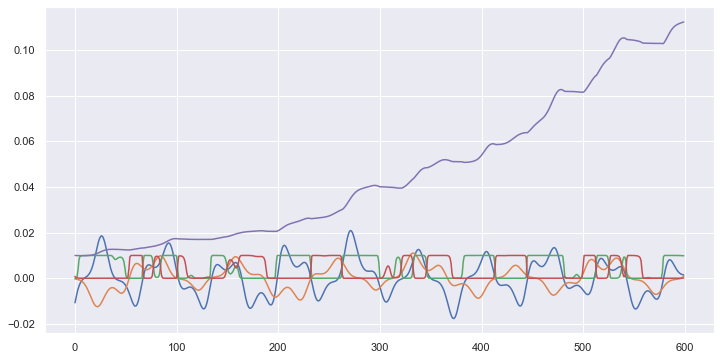

In [42]:
plot_behaviour(primary_actor, env, positions=[1,2], duration=600)

---
### The critic and the *true* Q-function

We expected to see the final critic function on the optimal trajectory match the *true* Q-function as computed from the rewards collected there. However, that is not the case as we can see below

In [35]:
mh, pw, actions, returns, mh1, pw1  = trading_trajectory(
    primary_actor, default_env, noise=None, duration = 256, hold = 1)

In [36]:
qvals = primary_critic([mh, pw, primary_actor([mh, pw])])

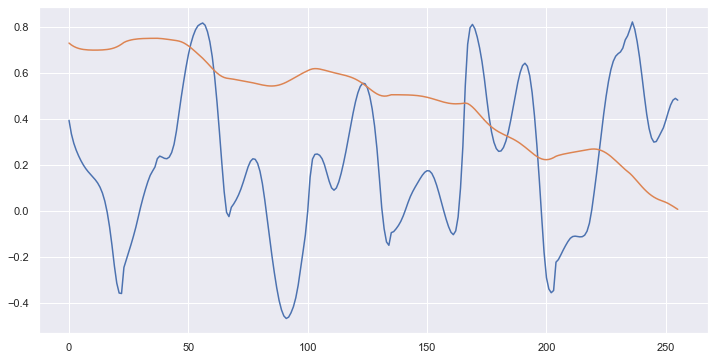

In [37]:
plt.plot(np.squeeze(qvals))
plt.plot(qfun_from_rewards(returns, gamma=GAMMA));

---
# Intermezzo: Playing with the Bellmann problem
Let's convince ourself that the Bellmann update does indeed converge to the expected maximum return on a fixed trajectory. Here, we look at a simple problem: Any step to the right, which is the only available action, will give some reward. 

In [42]:
N_T = 32

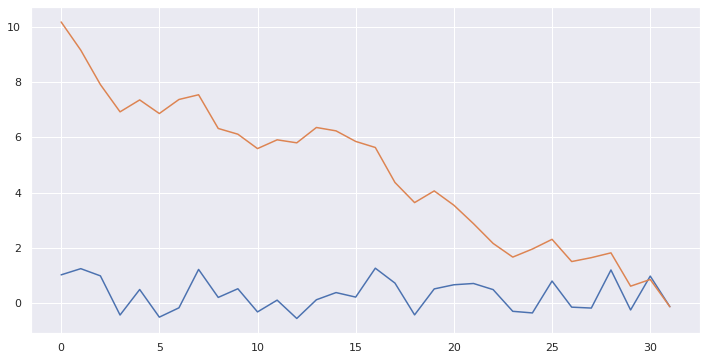

In [43]:
rewards=2*np.random.random(N_T)-.7
qfun = qfun_from_rewards(rewards, gamma=.999)
plt.plot(rewards)
plt.plot(qfun);

In [44]:
X_SCALE=1.
x = np.array( [[t, np.random.random()] for t in range(N_T)])
x_=x/X_SCALE #[:-1]

#### A simple neural network estimator

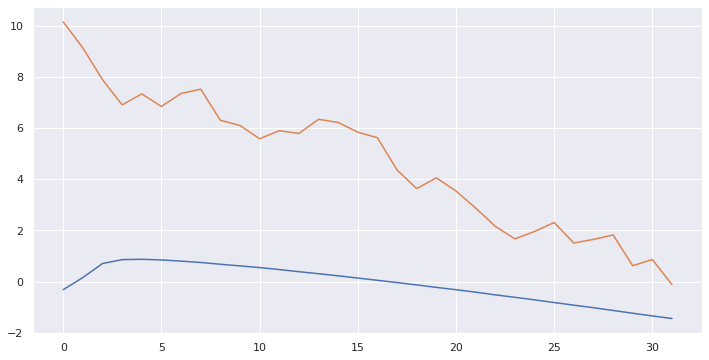

In [45]:
activation = tf.keras.activations.elu
#activation = 'relu'
inputs = tk.Input(shape=[2], dtype=tf.float32)
y = inputs

for u in [16, 32, 64, 16]:
    y = tkl.Dense(units=u, activation='elu')(y)

y = tkl.Dense(units=1, activation=None)(y)

outputs = y

loss = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

Q = tk.Model(inputs, outputs)

small_weights = [w/1.0 for w in Q.get_weights()]
Q.set_weights(small_weights)
Q.compile(optimizer, loss)
q_est = Q(x_).numpy()
plt.plot(q_est.T[0])
plt.plot(qfun);

### Fitting the estimator to the Bellmann targets

bellmann loss: [0.5646244883537292], mse from true Q: , 16.11182802939375
bellmann loss: [0.2621293067932129], mse from true Q: , 0.8094832835226822
bellmann loss: [0.2565539479255676], mse from true Q: , 0.6979410463826055
bellmann loss: [0.23000578582286835], mse from true Q: , 0.4960404931289418
bellmann loss: [0.2159184217453003], mse from true Q: , 0.382367437702259
bellmann loss: [0.23128333687782288], mse from true Q: , 0.4298403198508271
bellmann loss: [0.2554734945297241], mse from true Q: , 0.4804811568741835
bellmann loss: [0.22791258990764618], mse from true Q: , 0.5311444418177809
bellmann loss: [0.19912771880626678], mse from true Q: , 0.5950536179469488
bellmann loss: [0.19250762462615967], mse from true Q: , 0.9010620929640216
bellmann loss: [0.17049604654312134], mse from true Q: , 1.0610616494790024


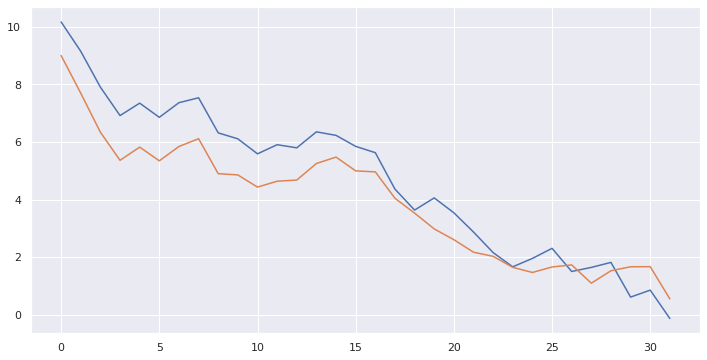

In [46]:
gamma=.99
for i in range(2001):
    y_t = [(rewards[t] + gamma * Q(np.expand_dims(x_[t+1], axis=0)).numpy()[0][0]) for t in range(N_T-1)]
    y_t.append(0.)
    history=Q.fit(x=x_, y=y_t, epochs=1, verbose=False)
    q_est = Q(x_).numpy()
    mse = np.mean((q_est.T - qfun)**2)
    if i % 200 == 0:
        print("bellmann loss: %s, mse from true Q: , %s" % (history.history['loss'], mse))

plt.plot(qfun)
plt.plot(q_est.T[0]);

We see that the Bellmann update (fitting the critic to the Bellmann targets) does what we expect it to do. Only it takes a long time for the effect to show up as a visual similarity. We don't do 2000 batches each time in the DDPG algorithm. Hence, it's plausible that the critic doesn't look like the Q-Function. The empirical success shows us, however, that it can still do the job as *adviser* to the actor.